In [90]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import cv2
import sqlite3
import pandas as pd

def is_float(s):
    try:
        float(s)
    except ValueError:
        return False
    else:
        return True
    
def offset2df(df,label,offset):
    l_multi=df_shot[label].values.tolist()
    l_multi_f = [float(s)-offset if is_float(s) else np.nan for s in l_multi]
    df[label+'_f']=l_multi_f
    return df

dbname = './nishioka-nakajima_6-3_6-7_4-6.db'
conn = sqlite3.connect(dbname)
c = conn.cursor()
#df_score = pd.read_sql("select * from score", conn)
df_score=pd.read_csv("./fix_score.csv")
df_match = pd.read_sql("select * from match", conn)
df_shot = pd.read_sql("select * from shot", conn)

# df_score_1set=df_score[df_score['Set']=='0-0']
# df_score_2set=df_score[df_score['Set']=='1-0']
# df_score_3set=df_score[df_score['Set']=='1-1']

#df_shotに'game' 'server'を追加する(df_gameを参照)
server_list=[]
game_list=[]
for i in range(len(df_shot['point'])):
    point=df_shot['point'][i]
    server_list.append(df_score[df_score['index']==point]['Server'].values[0])
    game_list.append(df_score[df_score['index']==point]['Game'].values[0])
    
df_shot['Server']=server_list
df_shot['Game']=game_list


#座標の基準を変える
x_offset=10.97/2
y_offset=23.78/2
df_shot=offset2df(df_shot,'ballx',x_offset)
df_shot=offset2df(df_shot,'bally',y_offset)
df_shot=offset2df(df_shot,'playerAx',x_offset)
df_shot=offset2df(df_shot,'playerAy',y_offset)
df_shot=offset2df(df_shot,'playerBx',x_offset)
df_shot=offset2df(df_shot,'playerBy',y_offset)


In [91]:
df_shot

,index,point,frame,ballx,bally,playerAx,playerAy,playerBx,playerBy,hitplayer,...,foreback,direction,Server,Game,ballx_f,bally_f,playerAx_f,playerAy_f,playerBx_f,playerBy_f
0,0,1,861.0,12.2,23.47,4.57,-1.97,10.0,23.47,Nishioka,...,Fore,Cross,Nakashima,0-0,6.715,11.58,-0.915,-13.86,4.515,11.58
1,1,2,1296.0,5.42,17.15,,,,,Nishioka,...,,Cross,Nakashima,0-0,-0.065,5.26,NaN,NaN,NaN,NaN
2,2,3,1730.0,9.26,16.21,,,,,Nishioka,...,,Cross,Nakashima,0-0,3.775,4.32,NaN,NaN,NaN,NaN
3,3,3,1742.0,13.96,24.5,4.57,-0.04,11.12,24.5,Nishioka,...,Fore,Cross,Nakashima,0-0,8.475,12.61,-0.915,-11.93,5.635,12.61
4,4,4,2241.0,2.23,16.56,,,,,Nishioka,...,,Cross,Nakashima,0-0,-3.255,4.67,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,1986,304,261291.0,3.98,-1.62,4.65,-1.62,5.72,26.08,Nakashima,...,Fore,Cross,Nishioka,4-5,-1.505,-13.51,-0.835,-13.51,0.235,14.19
1987,1987,304,261320.0,8.7,23.42,,,,,Nakashima,...,,Cross,Nishioka,4-5,3.215,11.53,NaN,NaN,NaN,NaN
1988,1988,304,261327.0,9.6,26.74,5.42,-1.85,8.37,26.74,Nakashima,...,Fore,Cross,Nishioka,4-5,4.115,14.85,-0.065,-13.74,2.885,14.85
1989,1989,304,261353.0,4.01,5.74,,,,,Nakashima,...,,Cross,Nishioka,4-5,-1.475,-6.15,NaN,NaN,NaN,NaN


In [73]:
df_score

,Unnamed: 0,index,StartFrame,EndFrame,Set,Game,Score,ScoreResult,FirstSecond,Server,...,ContactServeX,ContactServeY,Court1X,Court1Y,Court2X,Court2Y,Court3X,Court3Y,Court4X,Court4Y
0,0,0,0,699,NaN,NaN,NaN,NaN,1,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1,1,700,1250,0-0,0-0,0-0,15-0,2,Nakashima,...,0,0,0,0,0,0,0,0,0,0
2,2,2,1251,1695,0-0,0-0,15-0,30-0,1,Nakashima,...,0,0,0,0,0,0,0,0,0,0
3,3,3,1696,2221,0-0,0-0,30-0,40-0,1,Nakashima,...,0,0,0,0,0,0,0,0,0,0
4,4,4,2222,3175,0-0,0-0,40-0,40-15,1,Nakashima,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,301,301,258235,259361,1-1,4-5,15-30,15-40,1,Nishioka,...,0,0,0,0,0,0,0,0,0,0
302,302,302,259362,259637,NaN,NaN,NaN,NaN,1,NaN,...,0,0,0,0,0,0,0,0,0,0
303,303,303,259638,260933,1-1,4-5,15-40,30-40,2,Nishioka,...,0,0,0,0,0,0,0,0,0,0
304,304,304,260934,262240,1-1,4-5,30-40,0-0,1,Nishioka,...,0,0,0,0,0,0,0,0,0,0


nan


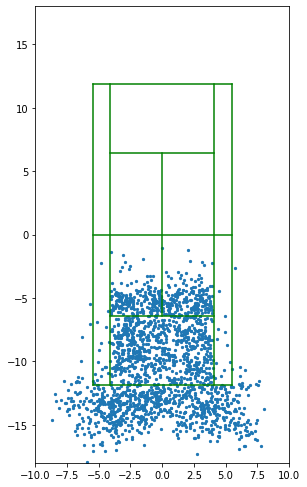

In [72]:
def drawCourt(ax):#テニスコートラインを描画
    x_offset=10.97/2
    y_offset=23.78/2
    #横線
    ax.plot([0-x_offset,10.97-x_offset], [11.89-y_offset,11.89-y_offset], color = "green")
    ax.plot([0-x_offset,10.97-x_offset], [0-y_offset,0-y_offset], color = "green")
    ax.plot([0-x_offset,10.97-x_offset], [11.89*2-y_offset,11.89*2-y_offset], color = "green")
    ax.plot([10.97/2-x_offset,10.97/2-x_offset], [5.49-y_offset,11.89*2-5.49-y_offset], color = "green")

    #縦線
    ax.plot([0-x_offset,0-x_offset], [0-y_offset,11.89*2-y_offset], color = "green")
    ax.plot([1.37-x_offset,1.37-x_offset], [0-y_offset,11.89*2-y_offset], color = "green")
    ax.plot([1.37+8.23-x_offset,1.37+8.23-x_offset], [0-y_offset,11.89*2-y_offset], color = "green")
    ax.plot([1.37+8.23+1.37-x_offset,1.37+8.23+1.37-x_offset], [0-y_offset,11.89*2-y_offset], color = "green")

    ax.plot([1.37-x_offset,1.37+8.23-x_offset], [5.49-y_offset,5.49-y_offset], color = "green")
    ax.plot([1.37-x_offset,1.37+8.23-x_offset], [11.89*2-5.49-y_offset,11.89*2-5.49-y_offset], color = "green")
    
    return ax

def plot_bounce(x,y):
    fig=plt.figure(figsize=(10.0, 10.0))
    ax1 = fig.add_subplot(1,2,1)
    # ax2 = fig.add_subplot(1,2,2)
    ax1=drawCourt(ax1)
    ax1.set_aspect('equal')
    ax1.scatter(x,y,s=5,label='1st')
    ax1.set_xlim(-10,10)
    ax1.set_ylim(-18,18)
    
def reverseXYList(xlist,ylist):
    xlist_r=[]
    ylist_r=[]
    for i, (x, y) in enumerate(zip(xlist, ylist)):
        if(y>0):
            y=-y
            x=-x
        xlist_r.append(x)
        ylist_r.append(y)
    ave = sum(ylist_r)/len(ylist_r)
    print(ave)
    return xlist_r,ylist_r,ave
    
ballx=df_shot['ballx_f'].values.tolist()
bally=df_shot['bally_f'].values.tolist()

ballx,bally,ave=reverseXYList(ballx,bally)

player_a_x=df_shot['playerAx_f'].values.tolist()
player_a_y=df_shot['playerAy_f'].values.tolist()

plot_bounce(ballx,bally)


In [63]:
ballx.values.tolist()

[6.714999999999999,
 -0.06500000000000039,
 3.7749999999999995,
 8.475000000000001,
 -3.2550000000000003,
 -6.255000000000001,
 -3.3850000000000002,
 -3.345,
 1.4849999999999994,
 2.8549999999999995,
 -2.0250000000000004,
 -4.055000000000001,
 1.5549999999999997,
 3.4050000000000002,
 2.874999999999999,
 3.2649999999999997,
 -0.3050000000000006,
 -1.0550000000000006,
 3.335,
 5.2749999999999995,
 3.634999999999999,
 6.825,
 -1.8850000000000002,
 -4.755000000000001,
 -0.7450000000000001,
 -1.7250000000000005,
 1.5949999999999998,
 2.8649999999999993,
 0.4950000000000001,
 0.34499999999999975,
 2.5149999999999997,
 4.1049999999999995,
 -2.845,
 -4.295,
 1.255,
 1.915,
 0.125,
 -0.375,
 -2.785,
 -4.335000000000001,
 -3.5950000000000006,
 -6.735,
 0.17499999999999982,
 0.8249999999999993,
 0.27499999999999947,
 0.2649999999999997,
 0.034999999999999254,
 -0.09500000000000064,
 -2.515,
 -3.575,
 2.6049999999999995,
 4.315,
 -2.7350000000000003,
 -3.4450000000000003,
 -1.9750000000000005,
 -

In [31]:
df_shot

,index,point,frame,ballx,bally,playerAx,playerAy,playerBx,playerBy,hitplayer,bouncehit,foreback,direction,ballx_f
0,0,1,861.0,12.2,23.47,4.57,-1.97,10.0,23.47,Nishioka,Hit,Fore,Cross,12.20
1,1,2,1296.0,5.42,17.15,,,,,Nishioka,Bounce,,Cross,5.42
2,2,3,1730.0,9.26,16.21,,,,,Nishioka,Bounce,,Cross,9.26
3,3,3,1742.0,13.96,24.5,4.57,-0.04,11.12,24.5,Nishioka,Hit,Fore,Cross,13.96
4,4,4,2241.0,2.23,16.56,,,,,Nishioka,Bounce,,Cross,2.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,1986,304,261291.0,3.98,-1.62,4.65,-1.62,5.72,26.08,Nakashima,Hit,Fore,Cross,3.98
1987,1987,304,261320.0,8.7,23.42,,,,,Nakashima,Bounce,,Cross,8.70
1988,1988,304,261327.0,9.6,26.74,5.42,-1.85,8.37,26.74,Nakashima,Hit,Fore,Cross,9.60
1989,1989,304,261353.0,4.01,5.74,,,,,Nakashima,Bounce,,Cross,4.01


In [20]:
x=df_shot['ballx'].values.tolist()
x_np=np.array(x,dtype='float')
#x = [float(s) for s in x]

ValueError: could not convert string to float: 

In [19]:
x_np

array(['12.2', '5.42', '9.26', ..., '9.6', '4.01', '2.73'], dtype='<U5')